In [1]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn import preprocessing # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

In [2]:
df = pd.read_csv('cdiabetes_data_upload.csv')

In [9]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [10]:
df.dtypes

Age                   int64
Gender                int64
Polyuria              int64
Polydipsia            int64
sudden weight loss    int64
weakness              int64
Polyphagia            int64
Genital thrush        int64
visual blurring       int64
Itching               int64
Irritability          int64
delayed healing       int64
partial paresis       int64
muscle stiffness      int64
Alopecia              int64
Obesity               int64
class                 int64
dtype: object

In [14]:
X = df.drop('class', axis=1).copy() 
X.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1


In [15]:
y = df['class'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

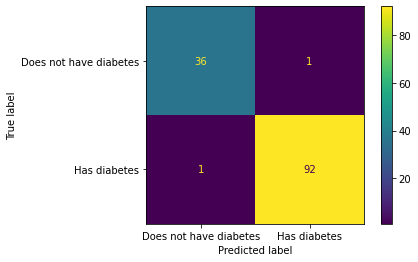

In [21]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      display_labels=["Does not have diabetes", "Has diabetes"])

In [22]:
num_features = np.size(X_train_scaled, axis=1)
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': [1/num_features, 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]
## NOTE: We are includeing C=1 and gamma=1/(num_features * X_train_scaled.var())
## as possible choices since they are the default values.
## ALSO NOTE: Because X_train_scaled.var() = 1 [remember, X_train_scaled = scale(X_train)],
## 1/(num_features * X_train_scaled.var()) = 1/num_features

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='roc_auc', # NOTE: The default value for scoring results in worse performance...
        ## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [23]:
clf_svm = SVC(random_state=42, C=10, gamma=1)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=1, random_state=42)

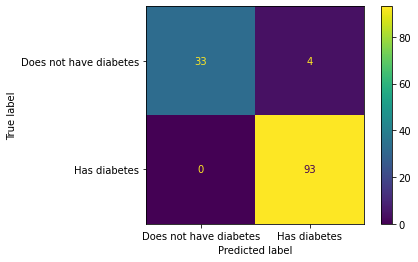

In [24]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test, 
                      display_labels=["Does not have diabetes", "Has diabetes"])

In [32]:
len(df.columns)

17

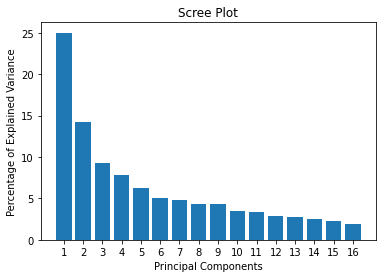

In [33]:
pca = PCA() # NOTE: By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [34]:
train_pc1_coords = X_train_pca[:, 0] 
train_pc2_coords = X_train_pca[:, 1]

## NOTE:
## pc1 contains the x-axis coordinates of the data after PCA
## pc2 contains the y-axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = preprocessing.scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

## Now we optimize the SVM fit to the x and y-axis coordinates
## of the data after PCA dimension reduction...
num_features = np.size(pca_train_scaled, axis=1)
param_grid = [
  {'C': [1, 10, 100, 1000], 
   'gamma': [1/num_features, 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='roc_auc', # NOTE: The default value for scoring results in worse performance...
        ## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


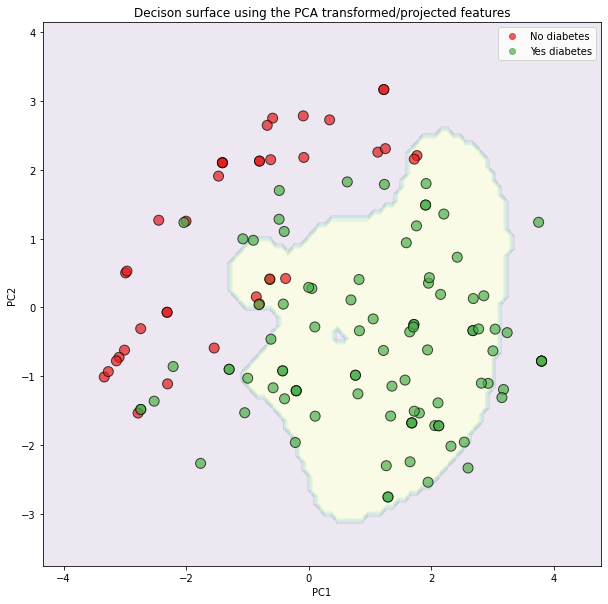

In [35]:
clf_svm = SVC(random_state=42, C=100, gamma=1)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA...
X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0] 
test_pc2_coords = X_test_pca[:, 1]

## Now create a matrix of points that we can use to show
## the decision regions.
## The matrix will be a little bit larger than the
## transformed PCA points so that we can plot all of
## the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## now we will classify every point in that 
## matrix with the SVM. Points on one side of the 
## classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Right now, Z is just a long array of lots of 0s and 1s, which
## reflect how each point in the mesh was classified.
## We use reshape() so that each classification (0 or 1) corresponds
## to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
## now we will use contourf() to draw a filled contour plot
## using the matrix values and classifications. 
## The contours will be filled according to the 
## predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

## now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## now draw the actual data points - these will
## be colored by their known (not predcited) classifications
## NOTE: setting alpha=0.7 lets us see if we are covering up a point 

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test, 
               cmap=cmap, 
               s=100, 
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## now create a legend
legend = ax.legend(scatter.legend_elements()[0], 
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No diabetes")
legend.get_texts()[1].set_text("Yes diabetes")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')
## plt.savefig('svm.png')
plt.show()